Choose problem and a train neural net

Let's solve [this](https://www.kaggle.com/c/histopathologic-cancer-detection) kaggle competition with FastAI library



1. Load the data

In [8]:
%env KAGGLE_USERNAME=<your kaggle username here>
%env KAGGLE_KEY=<your kaggle key here>
!kaggle competitions download -c histopathologic-cancer-detection -p cancer-detection-data

env: KAGGLE_USERNAME=kyrytruskovskiyk
env: KAGGLE_KEY=c67743cdcb0f11e705e07c8e8b53051d
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!ls ./cancer-detection-data/

models			   test      train.zip
sample_submission.csv	   test.zip  train_labels.csv
sample_submission.csv.zip  train     train_labels.csv.zip


In [ ]:
!mkdir cancer-detection-data/train
!unzip -q cancer-detection-data/train.zip -d cancer-detection-data/train

!mkdir cancer-detection-data/test
!unzip -q cancer-detection-data/test.zip -d cancer-detection-data/test

!unzip -q cancer-detection-data/train_labels.csv.zip -d cancer-detection-data/
!unzip -q cancer-detection-data/sample_submission.csv.zip -d cancer-detection-data/

2. Create ImageDataBunch and Visualization

In [11]:
import fastai.vision as fv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fastai.metrics import error_rate
from sklearn.metrics import roc_curve, auc


sns.set()
sns.set(style="darkgrid")

In [12]:
main_path = Path('./cancer-detection-data/')
main_path.ls()

[PosixPath('cancer-detection-data/train.zip'),
 PosixPath('cancer-detection-data/train'),
 PosixPath('cancer-detection-data/models'),
 PosixPath('cancer-detection-data/train_labels.csv'),
 PosixPath('cancer-detection-data/sample_submission.csv.zip'),
 PosixPath('cancer-detection-data/train_labels.csv.zip'),
 PosixPath('cancer-detection-data/test.zip'),
 PosixPath('cancer-detection-data/sample_submission.csv'),
 PosixPath('cancer-detection-data/test')]

In [13]:
df = pd.read_csv(main_path / 'train_labels.csv')

In [14]:
data = fv.ImageDataBunch.from_df(path=main_path, df=df, folder='train', suffix='.tif')

In [15]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

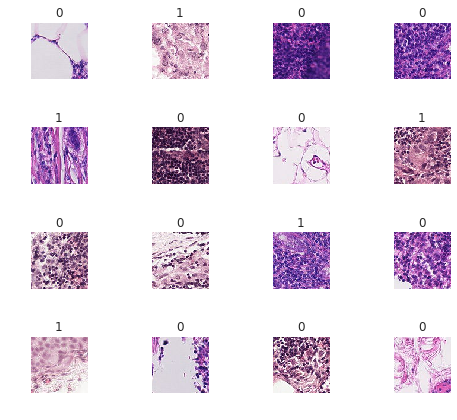

In [16]:
data.show_batch(rows=4, figsize=(7,6))

3. Training

In [17]:
learn = fv.create_cnn(data, fv.models.resnet50, metrics=error_rate)

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


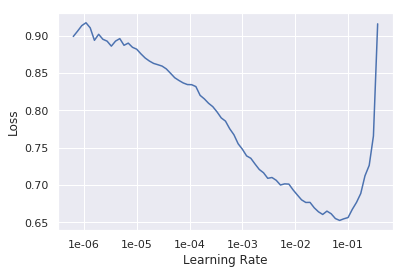

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(1, max_lr=slice(1e-3,1e-1))

epoch,train_loss,valid_loss,error_rate
1,0.185916,0.156511,0.057971


In [21]:
learn.save('stage-1')

4. Analyze model

In [22]:
interp = fv.ClassificationInterpretation.from_learner(learn)

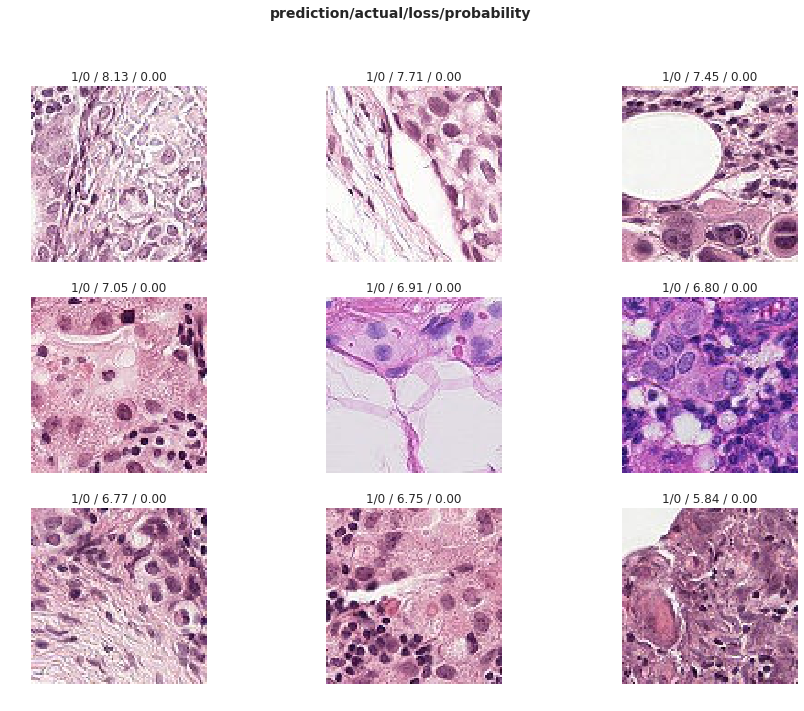

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

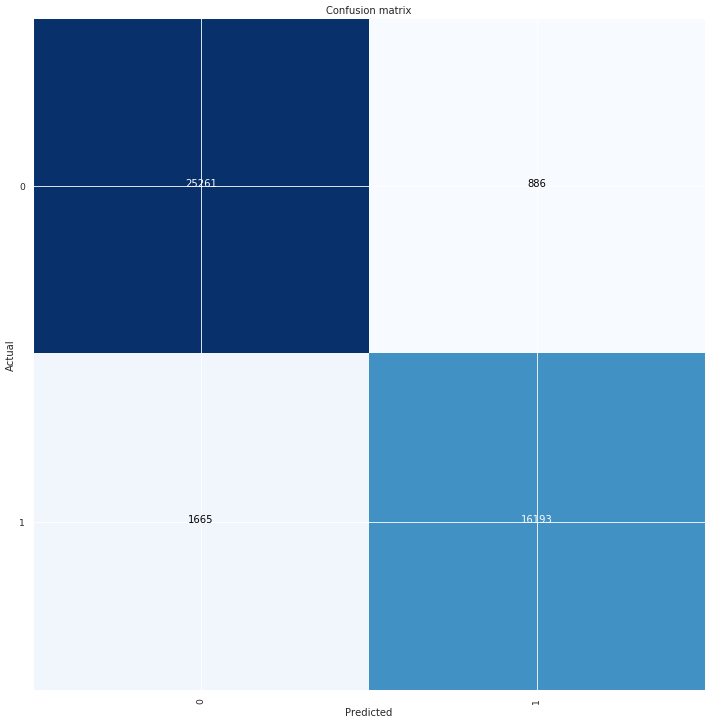

In [24]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [25]:
fpr, tpr, _ = roc_curve(interp.y_true.cpu().numpy(), interp.probs.cpu().numpy()[:, 1])
roc_auc = auc(fpr, tpr)

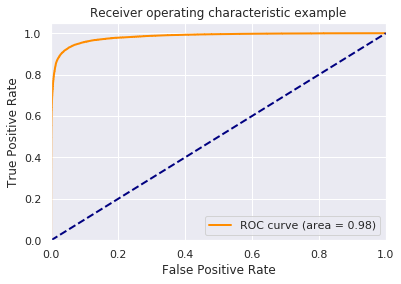

In [26]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

5. create submit

In [27]:
test_data = fv.ImageDataBunch.from_folder(main_path, test='test')
data.test_dl = test_data.test_dl
test_pred = learn.get_preds(ds_type=fv.DatasetType.Test)

In [28]:
subm = pd.read_csv(main_path / 'sample_submission.csv')
subm['label'] = test_pred[0][:, 1] > 0.5
subm['id'] = [x.name[:-4] for x in data.test_dl.dl.dataset.x.items]

In [29]:
subm.to_csv('subm.csv', index=False)

In [30]:
!head subm.csv

id,label
5c7be22f4a9d8722c4a6925ca7334a5f84cce8f5,1
39cbd94210b20340b2d3f8ffb6c409883f63c443,0
b3dc5f83be62626f94db5b28427da6d06e30a1eb,0
4773870cd76df710b5d4dd4178b634148ba6e777,1
575daf7c6760090b1fc671f7bf2fb6f6dfd3f789,1
8b0ef95d7ebdbdaaf83ae65b037d0b4a4c70553c,1
46fc9867433b6e3f559ef74c5977c8786e912b38,1
4baed3d3546a5775f9e066fedbfd202836d08a54,1
a3f6e0d6465564351bfe004e45c6aca6f320350a,0


In [31]:
!kaggle competitions submit -f 'subm.csv' -m "fast ai homework" histopathologic-cancer-detection

100%|██████████████████████████████████████| 2.36M/2.36M [00:00<00:00, 6.89MB/s]
Successfully submitted to Histopathologic Cancer Detection